### Import the required packages

In [1]:
import os
import tensorflow as tf
import keras
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
import warnings
warnings.filterwarnings('ignore')

### Generate Training and Validation Batch

In [250]:
#Use image data generator and apply various methods to upscale the training dataset and for validation only apply horizontal_flip
#we will also normalize the values between 0-1 (normally all values are in range 0-255) by using rescale.


batch_size=15
img_size=128 #decided based on the smallest size of image data available(check the codeblock above)

#Training Data Generator

train_directory = '/Users/ashishtomar/Data Science/Capstone Project/CNN - Mask 2/data/Train'

train_datagen = ImageDataGenerator(rescale=1/255,
                                   horizontal_flip=True,
                                   zoom_range=0.2,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   fill_mode='nearest') # all images will be rescaled to by 1./255

train_generator = train_datagen.flow_from_directory(train_directory,
                                                    target_size=(img_size,img_size),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=True)
#Validation Data Generator

val_directory = '/Users/ashishtomar/Data Science/Capstone Project/CNN - Mask 2/data/Validation'

val_datagen = ImageDataGenerator(rescale=1/255,horizontal_flip=True)

validation_generator = val_datagen.flow_from_directory(val_directory,
                                                    target_size=(img_size,img_size),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=True)

test_directory = '/Users/ashishtomar/Data Science/Capstone Project/CNN - Mask 2/data/Test'

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_directory(test_directory,
                                                    target_size=(img_size,img_size),
                                                    batch_size=batch_size,
                                                    class_mode='binary')



label_map = train_generator.class_indices
label_map

Found 2279 images belonging to 2 classes.
Found 1840 images belonging to 2 classes.
Found 261 images belonging to 2 classes.


{'WithMask': 0, 'WithoutMask': 1}

In [ ]:
#Location to store the model
 = "/Users/ashishtomar/Data Science/Capstone Project/CNN - Mask 2/best trained models"

### Create a CNN model

#### Add convolution layers
Considering images are tighly cropped around face add padding
Use activation method a relu
Use Maxpool and Dropout at each layer to avoid overfitting of the model
Add one dense layer (keeping model simple considering the small dataset)
For final dense layer, considering it is a binary classification, keep dimensionality unit as 1 (either 0 or 1) and use activation method as Sigmoid
#### Model compilation
Tried both optimizer, finally decided to use Adam(fast to train)
use loss as binary_crossentropy, it is suggested for binary classification

In [10]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3),padding='same', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
#model.add(Conv2D(512,(3,3), padding='same'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
#model.add(Dense(512))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

opt = Adam(lr=0.005)
#opt = RMSprop(lr=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       5

### Create a custom Callback which monitors training accuracy and validation loss

In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.91 and logs.get('val_loss')<0.4):
            print(f"\nReached {logs.get('accuracy')}% accuracy with validation loss : {logs.get('val_loss')} so cancelling training!")
            ModelCheckpoint("model_weights.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='auto',
                             verbose=1)
            self.model.stop_training = True

### Train and Evaluate Model

- Try for higher epochs
- While model is training, save the best performing model
- Stop the training when desired accuracy on training and loss on validation is reached
- Use ReduceLROnPlateau to slow down training when validation loss in not reducing
- Plot the accuracy and loss curve in realtime while training to keep track and also to figure out the best number of epochs

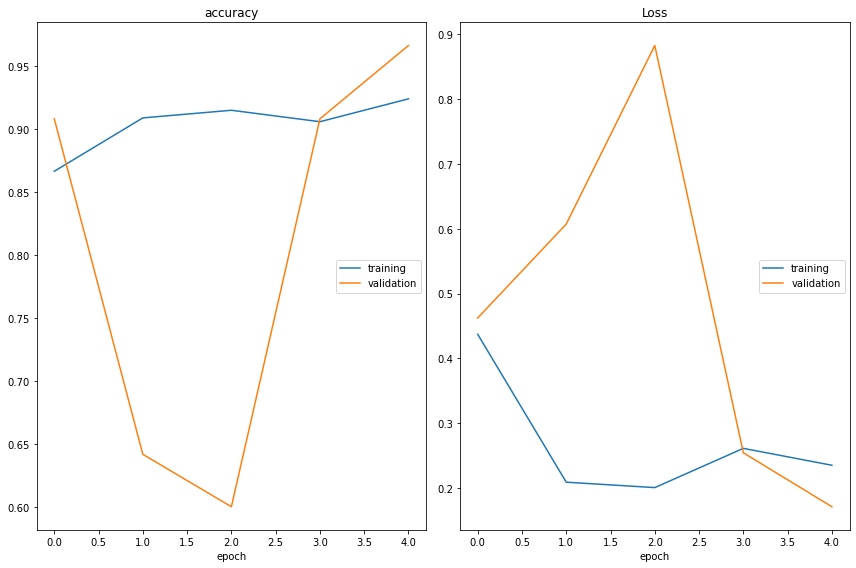

accuracy
	training         	 (min:    0.867, max:    0.924, cur:    0.924)
	validation       	 (min:    0.600, max:    0.967, cur:    0.967)
Loss
	training         	 (min:    0.201, max:    0.437, cur:    0.235)
	validation       	 (min:    0.171, max:    0.883, cur:    0.171)

Epoch 00005: val_accuracy improved from 0.90833 to 0.96667, saving model to model_weights.h5

Reached 0.9242424368858337% accuracy with validation loss : 0.17129158973693848 so cancelling training!


In [12]:

epochs=100
steps_per_epoch=len(train_generator)//batch_size
validation_steps = len(validation_generator)//batch_size

#print(len(train_generator))
#print(steps_per_epoch)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,#
                              patience=2,
                              verbose=1,
                              min_lr=0.0001,
                              mode='auto')

checkpoint = ModelCheckpoint("model_weights.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='auto',
                             verbose=1)

early_s = EarlyStopping(monitor='val_loss',
                        #min_delta=0,
                        patience=5,
                        verbose=1,
                        mode='auto',
                        restore_best_weights=True)


#callbacks = [PlotLossesKerasTF(),checkpoint]#,reduce_lr]
#callbacks = [checkpoint]#,reduce_lr]
#callbacks = [PlotLossesKerasTF(),reduce_lr]

callbacks = [PlotLossesKerasTF(),checkpoint,myCallback(),reduce_lr]
#callbacks = [myCallback()]

history=model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

### Save the model for later use or to deploy

In [ ]:
model.save(best_model)

#### Load the saved model to evaluate on test dataset

In [34]:
from tensorflow import keras
## load the model
model_load = keras.models.load_model(best_model)

## evaluate the test dataset
model_load.evaluate(test_generator)

18/18 [==============================] - 3s 187ms/step - loss: 0.1834 - accuracy: 0.9579


[0.1833585798740387, 0.9578543901443481]

model shows a really good performance on the test set

### Lets predict and plot each image in test dataset

In [459]:
## Create a list of all images
## Create a list of all predictions to plot

import numpy as np
from keras.preprocessing import image

content = os.path.join('/Users/ashishtomar/Data Science/Capstone Project/CNN - Mask 2/data/Test/WithMask/')
filenames_test = os.listdir(content)
images = []
classes =[]
for fn in filenames_test:
    path=content+fn
    #print(path)
    if not fn.startswith('.'):
        images.append(image.load_img(path, target_size=(128, 128)))
        img = image.load_img(path, target_size=(128, 128))
        #convert image to an array 
        x = image.img_to_array(img)
        # Convert single image to a batch
        x= np.array([x])
        prediction=model.predict(x)
        classes.append(round(model.predict(x)[0][0]))

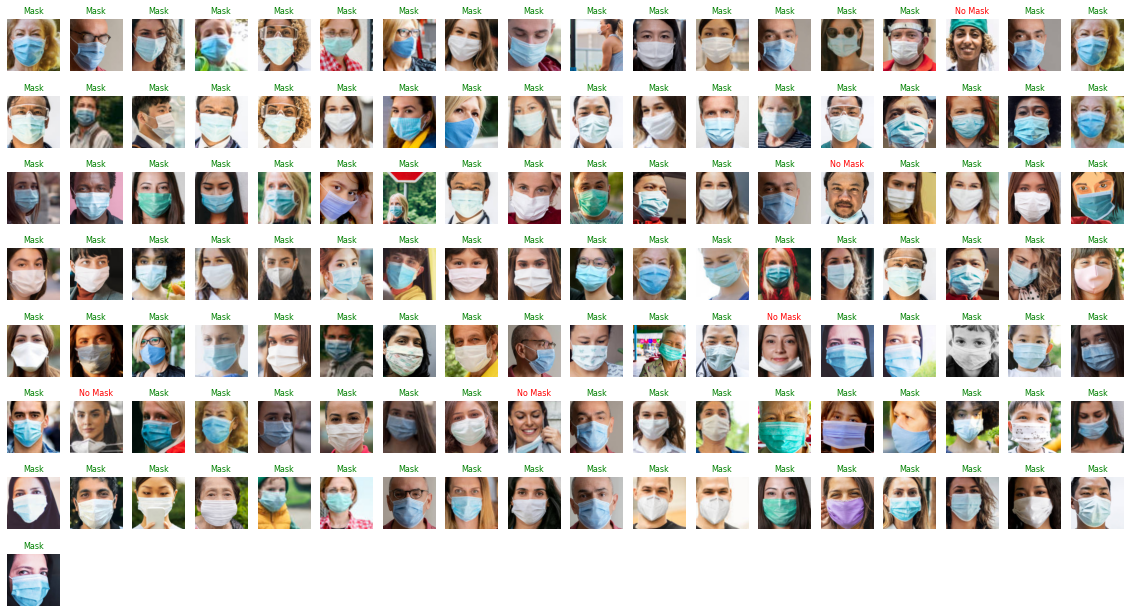

In [462]:
## Plot images with their predictions

import matplotlib.pyplot as plt
plt.figure(figsize=(20,11))
columns = 18
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    
    if classes[i]==0:
        plt.title("Mask",fontsize=8,color='green')
    else:
        plt.title("No Mask",fontsize=8,color='red')
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout(pad=20)

## Model Evaluation
- Create a confusion matrix
- Create a classification report to show f1-score, precision and recall
- Plot a ROC curve

#### To that we will first create a dataframe for
- File name in test dataset
- File path in test dataset
- True and Predicted text label of an image as "Mask" and "No-Mask"
- True and Predicted binary label of an image as "0" and "1"
- Probalistic score from the model prediction

In [442]:
#create a list of file name and file path for the dataframe
import cv2
import os
i=20000
from shutil import copy
i=0
label=[]
f_names=[]
f_path=[]
for (dirpath, dirnames, filenames) in os.walk(test_directory):   
    for i in filenames:
        if i!='.DS_Store':
            f_names.append(i)
            path=dirpath+'/'+i
            f_path.append(path)

In [443]:
# create a list of true labels for the dataframe
true_text_label=[]
true_bin_label=[]
for i in f_names:
    if i.startswith('mask'):
        true_text_label.append("Mask")
        true_bin_label.append(0)
    else:
        true_text_label.append("No-Mask")
        true_bin_label.append(1)

#### Create the dataframe
- File name in test dataset
- File path in test dataset
- True and Predicted text label of an image as "Mask" and "No-Mask"
- True and Predicted binary label of an image as "0" and "1"
- Probalistic score from the model prediction

In [444]:
# create the dataframe of file_name, file_path,true&pred text label, true and predicted binary label and a coulmn for probablistic score
import pandas as pd
#mydf = pd.DataFrame(list(zip(lstA, lstB)), columns = ['My List A', 'My List B'])
confusion_matrix_df=pd.DataFrame(list(zip(f_names, f_path,true_text_label,true_label,true_bin_label,true_label,true_label)), columns = ['file_name', 'file_path','true_text_label','pred_text_label','true_bin_label','pred_bin_label','prob_label'])
confusion_matrix_df

,file_name,file_path,true_text_label,pred_text_label,true_bin_label,pred_bin_label,prob_label
0,45122.png,/Users/ashishtomar/Data Science/Capstone Proje...,No-Mask,No-Mask,1,No-Mask,No-Mask
1,44994.png,/Users/ashishtomar/Data Science/Capstone Proje...,No-Mask,No-Mask,1,No-Mask,No-Mask
2,45095.png,/Users/ashishtomar/Data Science/Capstone Proje...,No-Mask,No-Mask,1,No-Mask,No-Mask
3,45081.png,/Users/ashishtomar/Data Science/Capstone Proje...,No-Mask,No-Mask,1,No-Mask,No-Mask
4,45042.png,/Users/ashishtomar/Data Science/Capstone Proje...,No-Mask,No-Mask,1,No-Mask,No-Mask
...,...,...,...,...,...,...,...
236,mask_53.jpg,/Users/ashishtomar/Data Science/Capstone Proje...,Mask,Mask,0,Mask,Mask
237,mask_47.jpg,/Users/ashishtomar/Data Science/Capstone Proje...,Mask,Mask,0,Mask,Mask
238,mask_46.jpg,/Users/ashishtomar/Data Science/Capstone Proje...,Mask,Mask,0,Mask,Mask
239,mask_85.jpg,/Users/ashishtomar/Data Science/Capstone Proje...,Mask,Mask,0,Mask,Mask


In [445]:
#Create a predictions
#create a list of predicted_text_label, predicted_bin_label and prob_label to update the dataframe

from keras.preprocessing import image
prob_label=[]
predicted_text_label=[]
predicted_bin_label=[]

for i in confusion_matrix_df['file_path']:
    img = image.load_img(i, target_size=(128, 128))
    #convert image to an array 
    x = image.img_to_array(img)
    # Convert single image to a batch
    x= np.array([x])
    prob=model.predict(x)[0][0]
    prediction=round(prob)
    predicted_bin_label.append(prediction)
    prob_label.append(prob)
    if prediction==0:
     predicted_text_label.append('Mask')
    else:
     predicted_text_label.append('No-Mask')

In [446]:
#Update the column in dataframe for predicted labels
confusion_matrix_df['pred_text_label']=predicted_text_label
confusion_matrix_df['pred_bin_label']=predicted_bin_label
confusion_matrix_df['prob_label']=prob_label

In [447]:
confusion_matrix_df

,file_name,file_path,true_text_label,pred_text_label,true_bin_label,pred_bin_label,prob_label
0,45122.png,/Users/ashishtomar/Data Science/Capstone Proje...,No-Mask,No-Mask,1,1,1.000000
1,44994.png,/Users/ashishtomar/Data Science/Capstone Proje...,No-Mask,No-Mask,1,1,0.969905
2,45095.png,/Users/ashishtomar/Data Science/Capstone Proje...,No-Mask,No-Mask,1,1,1.000000
3,45081.png,/Users/ashishtomar/Data Science/Capstone Proje...,No-Mask,No-Mask,1,1,1.000000
4,45042.png,/Users/ashishtomar/Data Science/Capstone Proje...,No-Mask,No-Mask,1,1,1.000000
...,...,...,...,...,...,...,...
236,mask_53.jpg,/Users/ashishtomar/Data Science/Capstone Proje...,Mask,Mask,0,0,0.000000
237,mask_47.jpg,/Users/ashishtomar/Data Science/Capstone Proje...,Mask,Mask,0,0,0.000000
238,mask_46.jpg,/Users/ashishtomar/Data Science/Capstone Proje...,Mask,Mask,0,0,0.000000
239,mask_85.jpg,/Users/ashishtomar/Data Science/Capstone Proje...,Mask,Mask,0,0,0.000000


#### Lets create a Confusion Matrix

Confusion Matrix!
Label 0 = Mask
Label 1 = No-Mask


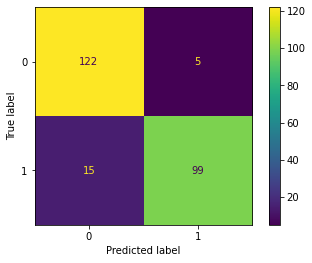

In [448]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predicted labels
#Y_pred = model.predict(test_generator)
y_pred=[]
for i in Y_pred:
    if i<=0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

# Generate confusion matrix
cf_matrix = confusion_matrix(confusion_matrix_df['true_text_label'], confusion_matrix_df['pred_text_label'])

# Plot
print(color.BOLD+"Confusion Matrix!"+color.PURPLE)
print("Label 0 = Mask")
print("Label 1 = No-Mask")
ConfusionMatrixDisplay(cf_matrix).plot()

plt.show()

In [449]:
from sklearn.metrics import classification_report

report_initial = classification_report(confusion_matrix_df['true_text_label'], confusion_matrix_df['pred_text_label'])
print(report_initial)

              precision    recall  f1-score   support

        Mask       0.89      0.96      0.92       127
     No-Mask       0.95      0.87      0.91       114

    accuracy                           0.92       241
   macro avg       0.92      0.91      0.92       241
weighted avg       0.92      0.92      0.92       241



##### Overall model has good f1 score for both Mask and No-Mask class
##### Model has performed well on predicting Mask class as compare to No-Mask
##### For Mask class, 5 out of 127 were incorrectly classified are were people are wearing masks but incorrectly
##### For No-Mask class, 15 out of 124 were incorrectly classified, in most cases there are object blocking face around mask area, definetly there is a scope of improvement

#### Lets generate the ROC curve

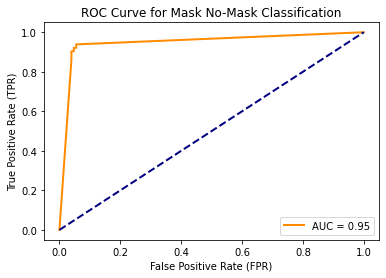

Area under curve (AUC):0.9471612101118939



In [463]:
### get probalistic prediction

from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(confusion_matrix_df['true_bin_label'], confusion_matrix_df['prob_label'])
roc_auc = roc_auc_score(confusion_matrix_df['true_bin_label'], confusion_matrix_df['prob_label'])

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Mask No-Mask Classification')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

#### Model is performing good as AUC=0.94 (closer to 1) which means there is a higher separability and predicting values either closer to 0(for mask) and 1(for no mask)

##### Lets see the model prediction on uncleaned and noisy data

In [210]:
## Its a class used for color formating the print
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'